In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
!pip install shap
import shap

shap.initjs()
%matplotlib inline

np.random.seed(3)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 20.5 MB/s 


## The data: Wisconsin Breast Cancer Dataset

For this demo, we will use the Wisconsin Breast Cancer Dataset, which contains 30 features extracted from an image of a fine needle aspirate (FNA) of a breast mass. These features represent different characterstics like the texture or the simmetry computed for each cell, and presented as the mean, standard deviation and "worst" (sum of the three largest values) of each of them.

In [4]:
!git clone https://github.com/sagihaider/Basic_ML_datasets.git
# data = pd.read_csv('../input/data.csv')

Cloning into 'Basic_ML_datasets'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 51 (delta 9), reused 0 (delta 0), pack-reused 27
Unpacking objects: 100% (51/51), done.


In [5]:
data = pd.read_csv('/content/Basic_ML_datasets/BCancer/bcancer.csv')

It also contains the `diagnosis` column as the label of the samples, which is `B` for benign results and ` M` for malign. For XGBoost to properly manage the data, we must transform all columns to numeric values. In this case, only transforming the `diagnosis` columns is necessary. Creating a binary `benign` columns indicating if the tumor was benign or not should suffice.

In [6]:
data['benign'] = (data.diagnosis == 'M').astype(int)

data['benign'].value_counts()

0    357
1    212
Name: benign, dtype: int64

We can drop the `id` and the original `diagnosis` column: we will not be using them anymore in this notebook. Also, let's split the data in the conventional names: `X` for the feature matrix, and `y` for the labels vector.

In [7]:
data.drop(['id', 'diagnosis'], axis=1, inplace=True)

features = [c for c in data.columns if c != 'benign']
target = 'benign'

X = data[features]
y = data[target]

We will be using a 5-folds cross validation to train the model. Remember kids, always cross-validate your results!

In [8]:
kfolds = KFold(n_splits=5, shuffle=True)

This one is a relatively well behaved dataset and we are not in a competition, so a minimal parametrization will be performed. The main thing to highlight is that using `binary:logistic` as objective function and `auc` as the evaluation metric seem to be adequeate for the task. Also, this will make the tree return continuous probabilities, which are always useful for this problemas. We can round later if needed.

In [9]:
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.2,
    'silent': 1,
    'nthreads': 2,
}

num_round = 10

thres = 0.5

The main cross validation loop runs, computing also the `scale_pos_weight` parameter (which compensates unbalanceness in the training data) per fold. The final results are quite satisfactory.

In [10]:
cnf = list()
auc = list()

for train_idx, test_idx in kfolds.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    param['scale_pos_weight'] = (y_train.size - y_train.sum()) / y_train.sum()    
    
    xg_train = xgb.DMatrix(
        X_train.values, feature_names=features, label=y_train.values
    )
    xg_test = xgb.DMatrix(
        X_test.values, feature_names=features, label=y_test.values
    )
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist, verbose_eval=False)
    preds = bst.predict(xg_test)
    
    cnf.append(confusion_matrix(y_test, (preds > thres).astype(int)))
    auc.append(roc_auc_score(y_test, preds))

cnf = sum(cnf)
auc = sum(auc) / len(auc)

'Average AUC: {:.04f}'.format(auc)

'Average AUC: 0.9842'

In the confusion matrix is also possible to see how the discrete predictions out of the probabilities have a great performance: an average precision of around 95%. Still, take into account that no parameter search or feature engineering has been performed, so there is plenty of room for improvement. This is, however, out of the scope of the kernel.

Text(42.0, 0.5, 'Observation')

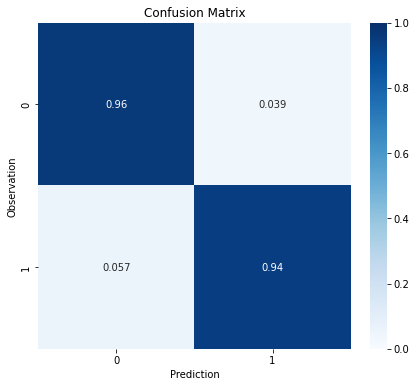

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))

normalized_cnf = cnf / cnf.sum(axis=1).reshape(-1, 1)

sns.heatmap(normalized_cnf, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=1)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

## Explaining the model with SHAP values

Using the SHAP module, we can generate different explainers: objects used to compute the SHAP values for each sample. These values are a representation of the impact of a certain feature in a prediction: positive values contribute to increase the final probability and negative values contribute to decrease it. This can be confusing now, but will get easier with the examples below.

We will compute these values for all the samples, `X`. This matrix, `shap_values`, is related with the training data: The element `shap_values[i, j]` is the SHAP value of the `i` sample's `j` feature. These values are not exclusive to XGBoost: plenty of other models have optimized explainers in SHAP, and the technique itself is model-agnostic. Refer to the [repository](https://github.com/slundberg/shap) for more details.

In [12]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)

The first artifact that can be generated with these values is a summary plot, which plots the most important features for the model along with a visual intuition on how they influence it. Due to these model's nature, each sample has to be studied individually, so most of these graphs are just an aggregation of all these samples.

We can see that, along with the name of a variable, there is a plot. In it, each point being a sample and its color the value of the feature in it, we can see its SHAP value in the horizontal axis. Take into account that high SHAP values contribute to the sample being benign, and low values contributing to it being malign.

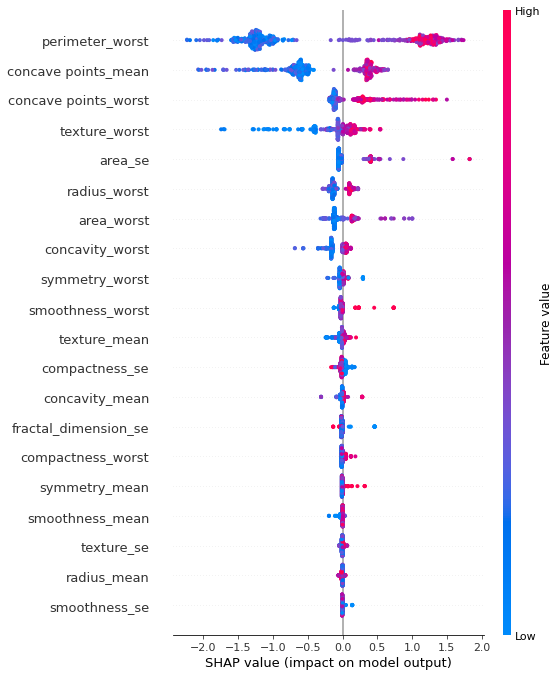

In [13]:
shap.summary_plot(shap_values, X) 

In the summary plot, we can see how the most important features for the model are `perimeter_worst`, `concave points_mean`, `concave points_worst`, `texture_worst` and `area_se` among others. Once the eye is trained enough, in a glimpse it is possible to see much more than that: `perimeter points_worst` values are correlated with their SHAP values (colors seem to advance in order from left to right), and it can be a really good indicator of benign tissue (the points in the right-most side of the graph are further from zero than in other variables. In the second variable, the `perimeter_worst` variable is not as disperse in its SHAP values, but the majority of values are not in zero (which implies no influence in the prediction).

We can take a step down the abstraction scale and see individual features dependence plots. These graphs plot the feature's value respect to its SHAP value, letting us understand easily how they are related. SHAP also plots a second variables value, which is automatically chosen depending its interaction with the feature at hand. That way the library helps us find multi-dimensional dependences in the data.

Below we can see the dependence plot of `perimeter_worst`: as seen in the dependence plot, higher values of the variable are related to higher SHAP values. We can also see that this relation is not linear, but closer to having a threshold around 110. We can also see how the color denotes that when the `perimeter_worst` has a low value, `texture_worst` makes the SHAP value lower the higher it is.

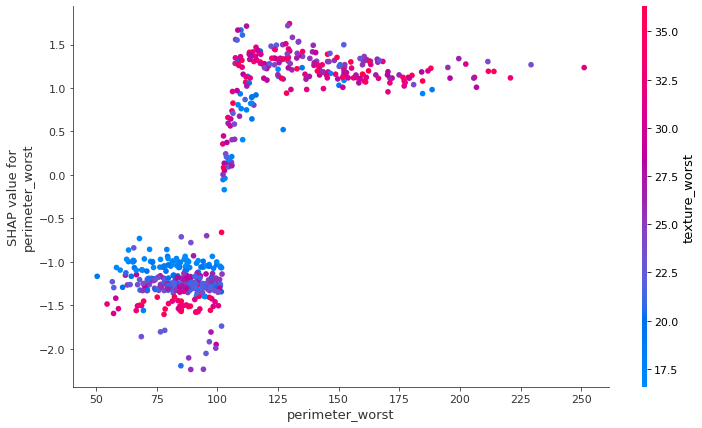

In [14]:
shap.dependence_plot('perimeter_worst', shap_values, X, dot_size=32, show=False)

pl.gcf().set_size_inches(12, 7)

Another interesting dependence plot is the one of `radius_worst`, that shows two clearly differentiated segments. This time, it is clear that low values of `radius_worst` imply a lower probability of it benign, and the samples in that segment with high `concavity_worst` seem to indicate a higher risk of malign tumors. High values of both `radius_worst` and `concavity_worse` indicate healthy tissue.

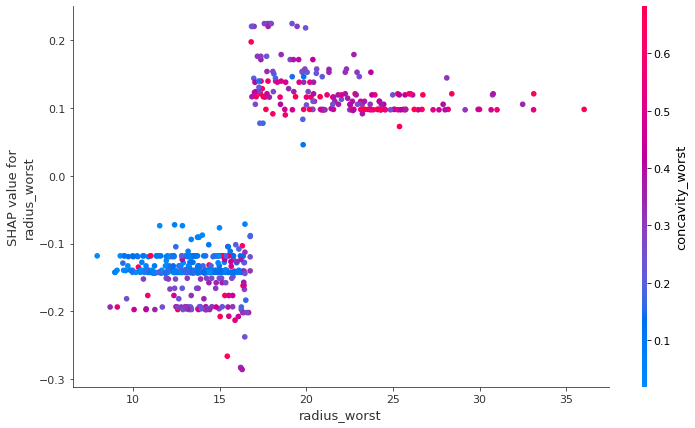

In [15]:
shap.dependence_plot('radius_worst', shap_values, X, dot_size=32, show=False)

pl.gcf().set_size_inches(12, 7)